## What are Auckland's crashiest roads?

Use open data and GeoPandas to find out

In [1]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as sg
import folium
import spectra
import json

DATA_DIR = Path('../data')
OUT_DIR = Path('../output')

%matplotlib inline

## Download data

1. NZ crash data from NZTA at http://www.nzta.govt.nz/safety/safety-resources/road-safety-information-and-tools/disaggregated-crash-data/ 
2. Auckland road geodata from Mapzen at https://s3.amazonaws.com/metro-extracts.mapzen.com/auckland_new-zealand.imposm-geojson.zip


## Prepare data

In [2]:
# Clean crash metadata
path = DATA_DIR/'disaggregated-crash-data-metadata.csv'
f = pd.read_csv(path, encoding='latin1')  # Ah, Windows

# Rename some
f = f.rename(columns={
    'Variable Name': 'variable',
    'Description': 'description',
  })

# Reformat some
f['variable'] = f['variable'].str.upper()
f = f[['variable', 'description']].copy()

path = DATA_DIR/'disaggregated-crash-data-metadata-cleaned.csv'
f.to_csv(path, index=False)

In [ ]:
# Filter crash data to last five years and save to (smaller) file
path = DATA_DIR/'disaggregated-crash-data.csv'
f = pd.read_csv(path)
f = f[f['CRASH_YEAR'] >= 2012].copy()

path = DATA_DIR/'nz_crashes_2012--2017.csv'
f.to_csv(path, index=False)


## Explore data

In [3]:
# Load Auckland roads as GeoDataFrame

path = DATA_DIR/'auckland_new-zealand_roads_gen1.geojson'  # 50 m tolerance
roads = gpd.read_file(str(path))
roads['osm_id'] = roads['osm_id'].astype(int).astype(str)
roads.head()

,osm_id,type,name,tunnel,bridge,oneway,ref,z_order,access,service,class,geometry
0,4077500,primary,Neilson Street,0,0,0,,6.0,,,highway,LINESTRING (174.7825679460168 -36.926756607184...
1,4077501,primary,Church Street,0,0,0,10,6.0,,,highway,LINESTRING (174.8133010321928 -36.920145632513...
2,4279302,secondary,Grafton Bridge,0,0,0,,5.0,yes,,highway,LINESTRING (174.7635943347171 -36.858437809893...
3,4279724,secondary,Victoria Street West,0,0,0,,5.0,,,highway,LINESTRING (174.7511958235428 -36.848174756190...
4,4279727,secondary,Hobson Street,0,0,1,,5.0,,,highway,LINESTRING (174.763198038335 -36.8445056618951...


In [4]:
# Project to New Zealand Transverse Mercator (NZTM) coordinates

WGS84 = {'init': 'epsg:4326'}
NZTM = {'no_defs': True, 'init': 'epsg:2193'}

print(roads.crs, 'Is that WGS84?', roads.crs == WGS84)

roads = roads.to_crs(NZTM)
print(roads.crs, 'Is that NZTM?', roads.crs == NZTM)

roads.head()

{'init': 'epsg:4326'} Is that WGS84? True
{'init': 'epsg:2193', 'no_defs': True} Is that NZTM? True


,osm_id,type,name,tunnel,bridge,oneway,ref,z_order,access,service,class,geometry
0,4077500,primary,Neilson Street,0,0,0,,6.0,,,highway,LINESTRING (1758765.076053659 5911768.63763862...
1,4077501,primary,Church Street,0,0,0,10,6.0,,,highway,LINESTRING (1761516.533885194 5912450.48134130...
2,4279302,secondary,Grafton Bridge,0,0,0,,5.0,yes,,highway,LINESTRING (1757215.13659337 5919379.770159338...
3,4279724,secondary,Victoria Street West,0,0,0,,5.0,,,highway,LINESTRING (1756130.656319006 5920538.74984815...
4,4279727,secondary,Hobson Street,0,0,1,,5.0,,,highway,LINESTRING (1757208.342740773 5920926.12962173...


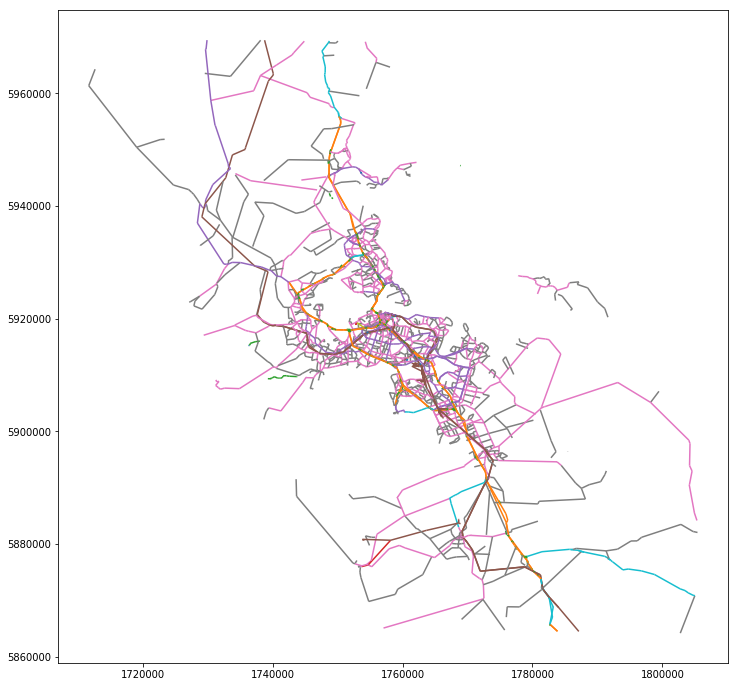

In [5]:
# Plot

f, ax = plt.subplots(1, figsize=(12, 12))
ax = roads.plot(column='type', ax=ax)
plt.show()


In [6]:
# Load NZ crash data as a DataFrame

path = DATA_DIR/'nz_crashes_2012--2017.csv'
crashes = pd.read_csv(path)
crashes.head().T

/home/araichev/.virtualenvs/introducing_geopandas-7e0rFXCM/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (21,34,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
CRASH_YEAR,2012,2012,2012,2012,2012
CRASH_FIN_YEAR,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012
CRASH_SEV,F,F,F,F,F
FATAL_COUNT,1,1,1,1,1
SERIOUSINJ_COUNT,0,0,0,0,0
MINORINJ_COUNT,0,2,1,0,0
MULTI_VEH,Vehicle(s)+Pedestrian(s),Multi vehicle,Vehicle(s)+Cyclist(s) only,Vehicle(s)+Pedestrian(s),Single vehicle
HOLIDAY,Christmas/New Year,None,None,None,None
LG_REGION_DESC,Auckland,Auckland,Bay of Plenty,Auckland,Northland
TLA_ID,7,7,23,7,1


In [7]:
# Filter Auckland crashes and drop bad locations

f = crashes.copy()
cond = f['LG_REGION_DESC'].str.contains('Auckland')
cond &= (f['EASTING'] > 0) & (f['NORTHING'] > 0)
#cond &= f['MULTI_VEH'].str.contains(r'cyclist|pedestrian', case=False)
f = f[cond].copy()
f.T



,0,1,3,9,11,14,15,18,21,23,...,188713,188714,188717,188718,188720,188722,188728,188730,188731,188732
CRASH_YEAR,2012,2012,2012,2012,2012,2012,2012,2012,2012,2012,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
CRASH_FIN_YEAR,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,...,2017/2018,2016/2017,2016/2017,2016/2017,2017/2018,2017/2018,2017/2018,2017/2018,2017/2018,2017/2018
CRASH_SEV,F,F,F,F,F,F,F,F,F,F,...,N,N,N,N,N,N,N,N,N,N
FATAL_COUNT,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
SERIOUSINJ_COUNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MINORINJ_COUNT,0,2,0,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
MULTI_VEH,Vehicle(s)+Pedestrian(s),Multi vehicle,Vehicle(s)+Pedestrian(s),Single vehicle,Vehicle(s)+Pedestrian(s),Multi vehicle,Single vehicle,Single vehicle,Multi vehicle,Vehicle(s)+Pedestrian(s),...,Multi vehicle,Multi vehicle,Single vehicle,Multi vehicle,Multi vehicle,Single vehicle,Single vehicle,Multi vehicle,Multi vehicle,Multi vehicle
HOLIDAY,Christmas/New Year,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
LG_REGION_DESC,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,...,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland
TLA_ID,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


In [8]:
# What's CRASH_SEV?

path = DATA_DIR/'disaggregated-crash-data-metadata-cleaned.csv'
tmp = pd.read_csv(path)

cond = tmp['variable'] == 'CRASH_SEV'
tmp.loc[cond, 'description'].iat[0]

"The severity of a crash. Possible values are 'F' (fatal), 'S' (serious), 'M' (minor), 'N' (non-injury). This is determined by the worst injury sustained in the crash at time of entry."

In [9]:
# Convert to GeoDataFrame in NZTM

geometry = [sg.Point(p) for p in zip(f['EASTING'], f['NORTHING'])]
crashes = gpd.GeoDataFrame(f, crs=NZTM, geometry=geometry)
crashes.T

,0,1,3,9,11,14,15,18,21,23,...,188713,188714,188717,188718,188720,188722,188728,188730,188731,188732
CRASH_YEAR,2012,2012,2012,2012,2012,2012,2012,2012,2012,2012,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
CRASH_FIN_YEAR,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,2011/2012,...,2017/2018,2016/2017,2016/2017,2016/2017,2017/2018,2017/2018,2017/2018,2017/2018,2017/2018,2017/2018
CRASH_SEV,F,F,F,F,F,F,F,F,F,F,...,N,N,N,N,N,N,N,N,N,N
FATAL_COUNT,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
SERIOUSINJ_COUNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MINORINJ_COUNT,0,2,0,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
MULTI_VEH,Vehicle(s)+Pedestrian(s),Multi vehicle,Vehicle(s)+Pedestrian(s),Single vehicle,Vehicle(s)+Pedestrian(s),Multi vehicle,Single vehicle,Single vehicle,Multi vehicle,Vehicle(s)+Pedestrian(s),...,Multi vehicle,Multi vehicle,Single vehicle,Multi vehicle,Multi vehicle,Single vehicle,Single vehicle,Multi vehicle,Multi vehicle,Multi vehicle
HOLIDAY,Christmas/New Year,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
LG_REGION_DESC,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,...,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland,Auckland
TLA_ID,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


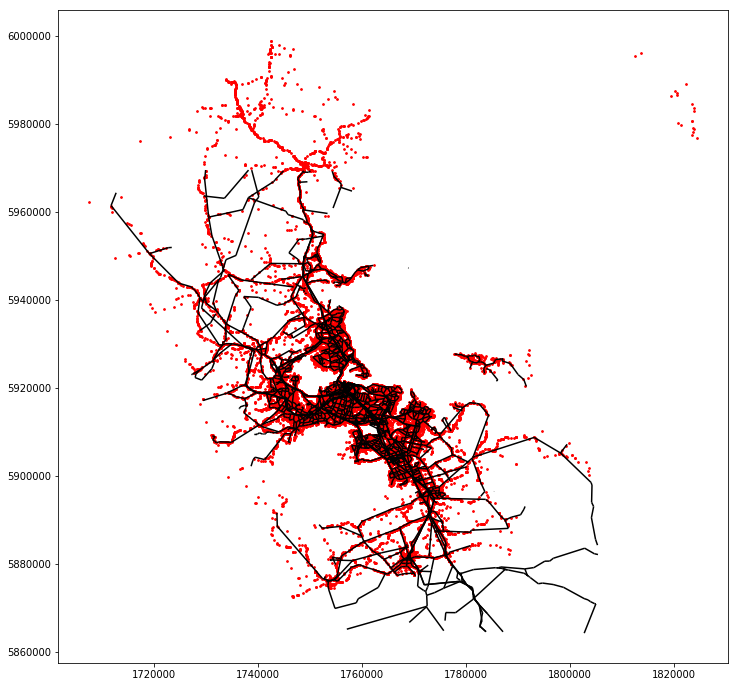

In [10]:
# Plot crashes on roads

f, ax = plt.subplots(1, figsize=(12, 12))
base = roads.plot(color='black', ax=ax)
crashes.plot(ax=base, marker='o', color='red', markersize=3)
plt.show()

## Address our question

In [46]:
# For each road collect the crashes near it

r = roads[['geometry', 'osm_id', 'name', 'class']].copy()

# Buffer crash points
buffer = 5  # meters
c = crashes[['geometry', 'CRASH_SEV']].copy()
c['geometry'] = c['geometry'].buffer(buffer)

# Spatial-join roads and buffered crash points 
f = gpd.sjoin(r, c, how='inner', op='intersects')
f

CPU times: user 7.35 s, sys: 4 ms, total: 7.35 s
Wall time: 7.36 s


,geometry,osm_id,name,class,index_right,CRASH_SEV
0,LINESTRING (1758765.076053659 5911768.63763862...,4077500,Neilson Street,highway,150782,N
94,LINESTRING (1758188.337122448 5911911.60221063...,4309879,,highway,150782,N
3322,LINESTRING (1758765.076053659 5911768.63763862...,117599450,Gloucester Park Road,highway,150782,N
6281,LINESTRING (1758754.653538544 5911725.29579590...,356370853,Gloucester Park Road,highway,150782,N
0,LINESTRING (1758765.076053659 5911768.63763862...,4077500,Neilson Street,highway,180726,N
94,LINESTRING (1758188.337122448 5911911.60221063...,4309879,,highway,180726,N
3322,LINESTRING (1758765.076053659 5911768.63763862...,117599450,Gloucester Park Road,highway,180726,N
6281,LINESTRING (1758754.653538544 5911725.29579590...,356370853,Gloucester Park Road,highway,180726,N
0,LINESTRING (1758765.076053659 5911768.63763862...,4077500,Neilson Street,highway,62697,M
94,LINESTRING (1758188.337122448 5911911.60221063...,4309879,,highway,62697,M


In [58]:
# Assign a crash score to each road.
# Use the number of crashes per meter.
# Alternatively, could weight crashes by severity, but won't do that here.

f['num_crashes'] = 1

g = f.groupby('osm_id', as_index=False).agg({
  'num_crashes': 'sum', 
  'name': 'first',
  'geometry': 'first',
  })
g = gpd.GeoDataFrame(g, crs=NZTM)  # Lost GeoDataFrame during groupby :(
g['length'] = g.geometry.length
g['crash_score'] = g['num_crashes']/g['length']
g = g.sort_values('crash_score', ascending=False)
crashy_roads = g.copy()

# Save to file
path = OUT_DIR/'auckland_crashy_roads.geojson'
with path.open('w') as tgt:
     tgt.write(crashy_roads.to_crs(WGS84).to_json())

crashy_roads


,osm_id,name,num_crashes,geometry,length,crash_score
2924,334450327,Massey Road,44,LINESTRING (1761710.035363007 5906529.77931559...,5.241659,8.394289
2934,335856862,Maioro Street,26,LINESTRING (1753570.495817483 5914448.51380269...,5.591830,4.649641
2854,326487533,Massey Road,34,LINESTRING (1763374.763724625 5908433.15188175...,7.821663,4.346902
89,114133938,Symonds Street,30,LINESTRING (1757211.462371929 5919373.89371228...,6.930551,4.328660
4635,8139192,Green Lane East,36,"LINESTRING (1760129.94972035 5915912.18995672,...",8.469985,4.250303
1245,154227191,,23,LINESTRING (1763904.445168815 5912490.33971071...,6.666481,3.450096
2058,26543370,,37,LINESTRING (1755492.11999104 5929000.508587312...,11.565260,3.199236
3725,478029707,,19,LINESTRING (1761458.74498503 5914305.879263636...,6.037364,3.147069
726,147841782,Lincoln Road,32,LINESTRING (1745376.569319429 5920374.88892483...,12.085093,2.647890
1246,154227192,,19,LINESTRING (1763883.968352459 5912595.11450732...,7.180216,2.646160


# Visualize the crashiest roads

In [59]:
# Color-code roads by crash score with Spectra 

cr = crashy_roads.round(3)
cr = gpd.GeoDataFrame(cr, crs=NZTM)  # Lost the geodataframe during rounding :(

print(cr.describe())
cuts = [0] + [cr['crash_score'].quantile(k/100) for k in [25, 50, 75, 98, 100]]

colors = reversed(['#d7191c', '#d7191c','#fdae61','#ffffbf','#abdda4','#2b83ba'])
scale = spectra.scale(colors).colorspace('lch').domain(cuts)
cr['color'] = cr['crash_score'].map(lambda x: scale(x).hexcode)

       num_crashes        length  crash_score
count  4901.000000   4901.000000  4901.000000
mean     11.032034    425.968416     0.093316
std      15.089596    771.656776     0.277148
min       1.000000      4.203000     0.000000
25%       2.000000     71.170000     0.010000
50%       5.000000    218.820000     0.028000
75%      14.000000    512.832000     0.076000
max     183.000000  14707.526000     8.394000


In [60]:
# Plot on a slippy map with Folium

cr = cr.to_crs(WGS84) 
lon, lat = cr.geometry.iat[0].coords[0]  # Center on crashiest road
tiles = 'https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png'
mappy = folium.Map(location=[lat, lon], zoom_start=16, tiles=tiles, attr='OSM')

def style(x):
    return {
        'color': x['properties']['color'],
        'weight': 5,
    }

geo = json.loads(cr.sort_values('crash_score').to_json())
folium.GeoJson(geo, 
  style_function=style).add_to(mappy)

mappy


## Further exploration

- Use better resolution roads
- Do analysis on road name rather than road ID
- Choose a different metric?
- Forget roads and focus on areas; use a heatmap